# Load Dependency

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor,\
GradientBoostingRegressor,BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,mean_absolute_error
from script.utils import genDescMap,maxminscale,readMolandAtom,getmorganfp,calc_rdkit_desc,calc_Dscribe_Desc,\
process_desc,genCompoundWiseDesc
from scipy.stats import pearsonr
from openbabel.pybel import (readfile,Outputfile)
import glob
import seaborn as sns
import matplotlib.pyplot as plt
random_seed = 2022

# Data Preprocess

In [3]:
dataset = pd.read_csv('./dataset.csv',index_col=0)
biaryl_smiles = dataset['Biaryl'].to_list()
olefin_smiles = dataset['Olefin'].to_list()
tdg_smiles = dataset['TDG'].to_list()

additive_smiles = dataset['Additive'].to_list()
solvent_smiles = dataset['Solvent'].to_list()
current = dataset['Current(mA)'].to_list()
temperature = dataset['Temperature'].to_list()

ee = dataset['ee'].to_numpy()
ddG = dataset['ddG(kcal/mol)'].to_numpy()

biaryl_smi_set = list(set(biaryl_smiles))
olefin_smi_set = list(set(olefin_smiles))
tdg_smi_set = list(set(tdg_smiles))

## PhysOrg Descriptor Generation

In [4]:
biaryl_desc_map,biaryl_desc_names = genDescMap('./descriptors/biaryl_desc_map.csv',True)
olefin_desc_map,olefin_desc_names = genDescMap('./descriptors/olefin_desc_map.csv',True)
tdg_desc_map,tdg_desc_names = genDescMap('./descriptors/tdg_desc_map.csv',True)
physorg_desc_map = {}
physorg_desc_map.update(biaryl_desc_map)
physorg_desc_map.update(olefin_desc_map)
physorg_desc_map.update(tdg_desc_map)
add_desc_map = genDescMap('./descriptors/add_desc_map.csv')
sol_desc_map = genDescMap('./descriptors/sol_desc_map.csv')
physorg_desc = genCompoundWiseDesc(biaryl_smiles,olefin_smiles,tdg_smiles,physorg_desc_map,False)
condition_desc = maxminscale(np.array([np.concatenate([add_desc_map[additive_smiles[i]],sol_desc_map[solvent_smiles[i]],
                                 np.array([current[i],temperature[i]])]) for i in range(len(dataset))]))

physorg_react_desc = np.concatenate([physorg_desc,condition_desc],axis=1)

## Other Descptor Generation

### Generate Geometry Map

In [5]:
all_smi_set = biaryl_smi_set + olefin_smi_set + tdg_smi_set
mmff94_geom_files = glob.glob('./geometries/mmff94-level/*.sdf')
smi_atoms_map = {}
smi_mol_map = {}
for file in mmff94_geom_files:
    smi,mol,atoms = readMolandAtom(file)
    smi_atoms_map[smi] = atoms
    smi_mol_map[smi] = mol

In [6]:
def get_atom_species(smiles_set):
    species = []
    for smi in smiles_set:
        species += [atom.GetSymbol() for atom in smi_mol_map[smi].GetAtoms()]
    return list(set(species))

reactant_atom_species = get_atom_species(biaryl_smi_set+olefin_smi_set)
tdg_atom_species = get_atom_species(tdg_smi_set)

### RDKit/FP

In [7]:
smi_rdkit_map = {smi:calc_rdkit_desc(smi_mol_map[smi]) for smi in all_smi_set}
smi_mf_map = {smi:getmorganfp(smi_mol_map[smi]) for smi in all_smi_set}

### MBTR

In [8]:
mbtr_parameter_dict = {'k1':{
                             "geometry": {"function": "atomic_number"},
                             "grid": {"min": 0, "max": 8, "n": 10, "sigma": 0.1}},
                       'k2':{
                            "geometry": {"function": "inverse_distance"},
                            "grid": {"min": 0, "max": 4, "n": 10, "sigma": 0.1},
                            "weighting": {"function": "exponential", "scale": 0.5, "cutoff": 1e-3}},
                       'k3':{
                            "geometry": {"function": "cosine"},
                            "grid": {"min": -1, "max": 4, "n": 10, "sigma": 0.1},
                            "weighting": {"function": "exponential", "scale": 0.5, "cutoff": 1e-3}},
                       'periodic':False,'normalization':'l2_each'
                      }


smi_mbtr_map = {}
for smi in biaryl_smi_set+olefin_smi_set:
    smi_mbtr_map[smi] = calc_Dscribe_Desc(smi,smi_atoms_map,reactant_atom_species,mbtr_parameter_dict,type_='MBTR')
for smi in tdg_smi_set:
    smi_mbtr_map[smi] = calc_Dscribe_Desc(smi,smi_atoms_map,tdg_atom_species,mbtr_parameter_dict,type_='MBTR')


### ACSF

In [9]:
acsf_parameter_dict = {'rcut':6,
                       'g2_params':[[1, 1], [1, 2], [1, 3]],
                       'g4_params':[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]]}

smi_acsf_map = {}
for smi in biaryl_smi_set+olefin_smi_set:
    smi_acsf_map[smi] = calc_Dscribe_Desc(smi,smi_atoms_map,reactant_atom_species,acsf_parameter_dict,type_='ACSF')
for smi in tdg_smi_set:
    smi_acsf_map[smi] = calc_Dscribe_Desc(smi,smi_atoms_map,tdg_atom_species,acsf_parameter_dict,type_='ACSF')

### LMBTR

In [10]:
lmbtr_parameter_dict = {"k2":{
                                "geometry": {"function": "distance"},
                                "grid": {"min": 0, "max": 5, "n": 100, "sigma": 0.1},
                                "weighting": {"function": "exponential", "scale": 0.5, "cutoff": 1e-3},
                              },
                        "k3":{
                                "geometry": {"function": "cosine"},
                                "grid": {"min": -1, "max": 4, "n": 100, "sigma": 0.1},
                                "weighting": {"function": "exponential", "scale": 0.5, "cutoff": 1e-3},
                             },
                        "periodic":False,"normalization":"l2_each"
                       }
smi_lmbtr_map = {}
for smi in biaryl_smi_set+olefin_smi_set:
    smi_lmbtr_map[smi] = calc_Dscribe_Desc(smi,smi_atoms_map,reactant_atom_species,lmbtr_parameter_dict,type_='LMBTR')
for smi in tdg_smi_set:
    smi_lmbtr_map[smi] = calc_Dscribe_Desc(smi,smi_atoms_map,tdg_atom_species,lmbtr_parameter_dict,type_='LMBTR')


### Generate Reaction Descriptors

In [12]:
rdkit_desc = genCompoundWiseDesc(biaryl_smiles,olefin_smiles,tdg_smiles,smi_rdkit_map)
mf_desc = genCompoundWiseDesc(biaryl_smiles,olefin_smiles,tdg_smiles,smi_mf_map)
mbtr_desc = genCompoundWiseDesc(biaryl_smiles,olefin_smiles,tdg_smiles,smi_mbtr_map)
acsf_desc = genCompoundWiseDesc(biaryl_smiles,olefin_smiles,tdg_smiles,smi_acsf_map)
lmbtr_desc = genCompoundWiseDesc(biaryl_smiles,olefin_smiles,tdg_smiles,smi_lmbtr_map)

rdkit_react_desc = np.concatenate([rdkit_desc,condition_desc],axis=1)
mf_react_desc = np.concatenate([mf_desc,condition_desc],axis=1)
mbtr_react_desc = np.concatenate([mbtr_desc,condition_desc],axis=1)
acsf_react_desc = np.concatenate([acsf_desc,condition_desc],axis=1)
lmbtr_react_desc = np.concatenate([lmbtr_desc,condition_desc],axis=1)

# Evaluate Different ML Models and Descriptors

In [13]:
models = [RandomForestRegressor(n_jobs=-1,random_state=random_seed),ExtraTreesRegressor(n_jobs=-1,random_state=random_seed),
          GradientBoostingRegressor(random_state=random_seed),XGBRegressor(n_jobs=-1,random_state=random_seed),
          BaggingRegressor(n_jobs=-1,random_state=random_seed),MLPRegressor(hidden_layer_sizes=(100,100),max_iter=1000,
          random_state=random_seed),AdaBoostRegressor(RandomForestRegressor(n_jobs=-1,random_state=random_seed),
                                                      random_state=random_seed)]
model_names = ['RF','ET','GB','XGB','BG','NN','Ada']
descs = [physorg_react_desc,rdkit_react_desc,mf_react_desc,acsf_react_desc,lmbtr_react_desc,mbtr_react_desc]
desc_names = ['PhysOrg','RDKit','MF','ACSF','LMBTR','MBTR']
performance_result = {}
test_index = [21, 58, 61, 110, 112, 114, 116, 122, 124, 127]
train_val_index = list(set(range(len(dataset))) - set(test_index))
kfold = KFold(n_splits=10,shuffle=True,random_state=random_seed)
for model_name,model in zip(model_names,models):
    for desc_name,desc in zip(desc_names,descs):
        
        train_val_desc,train_val_target = desc[train_val_index],ddG[train_val_index]
        all_test_y = []
        all_test_p = []
        for train_idx,test_idx in kfold.split(train_val_desc):
            train_x,test_x = train_val_desc[train_idx],train_val_desc[test_idx]
            train_y,test_y = train_val_target[train_idx],train_val_target[test_idx]
            test_P = []
            for try_ in range(10): 
                model.fit(train_x,train_y)
                test_p = model.predict(test_x)
                test_P.append(test_p)
            test_p = np.mean(test_P,axis=0)
            all_test_p.append(test_p)
            all_test_y.append(test_y)
        all_test_p = np.concatenate(all_test_p)
        all_test_y = np.concatenate(all_test_y)
        mae = mean_absolute_error(all_test_y,all_test_p)
        r2 = r2_score(all_test_y,all_test_p)
        pearson_r,_ = pearsonr(all_test_y,all_test_p)
        performance_result[(model_name,desc_name)] = [mae,r2,pearson_r,all_test_y,all_test_p]
        print('Model: %4s, Desc: %4s, R2: %.4f, PearsonR: %.4f, MAE: %.4f'%(model_name,desc_name,r2,pearson_r,mae))

Model:   RF, Desc: PhysOrg, R2: 0.8934, PearsonR: 0.9459, MAE: 0.2686
Model:   RF, Desc: RDKit, R2: 0.8810, PearsonR: 0.9396, MAE: 0.2762
Model:   RF, Desc:   MF, R2: 0.9022, PearsonR: 0.9500, MAE: 0.2496
Model:   RF, Desc: ACSF, R2: 0.8668, PearsonR: 0.9342, MAE: 0.2944
Model:   RF, Desc: LMBTR, R2: 0.9007, PearsonR: 0.9506, MAE: 0.2570
Model:   RF, Desc: MBTR, R2: 0.8948, PearsonR: 0.9470, MAE: 0.2616
Model:   ET, Desc: PhysOrg, R2: 0.9177, PearsonR: 0.9584, MAE: 0.2282
Model:   ET, Desc: RDKit, R2: 0.8727, PearsonR: 0.9345, MAE: 0.2654
Model:   ET, Desc:   MF, R2: 0.9089, PearsonR: 0.9536, MAE: 0.2229
Model:   ET, Desc: ACSF, R2: 0.8839, PearsonR: 0.9403, MAE: 0.2675
Model:   ET, Desc: LMBTR, R2: 0.9000, PearsonR: 0.9493, MAE: 0.2447
Model:   ET, Desc: MBTR, R2: 0.9022, PearsonR: 0.9499, MAE: 0.2431
Model:   GB, Desc: PhysOrg, R2: 0.8859, PearsonR: 0.9414, MAE: 0.2790
Model:   GB, Desc: RDKit, R2: 0.8235, PearsonR: 0.9091, MAE: 0.3137
Model:   GB, Desc:   MF, R2: 0.8786, PearsonR: 0

In [15]:
performance_result

{('RF', 'PhysOrg'): [0.2686358249278835,
  0.893436689903777,
  0.9458500608930615,
  array([2.93931419, 0.32439118, 3.61280604, 2.77285154, 0.3812557 ,
         2.42759961, 2.10588575, 2.5788515 , 2.77285154, 2.77285154,
         2.77285154, 2.77285154, 3.50752246, 2.77285154, 3.50752246,
         2.5788515 , 0.69309407, 0.81952066, 0.64235753, 0.72797759,
         1.32025148, 2.30338033, 3.04488153, 3.50752246, 3.50752246,
         3.50752246, 2.5788515 , 0.59331169, 3.50752246, 1.38539563,
         0.64235753, 1.2308122 , 2.77285154, 2.10588575, 2.30338033,
         3.04488153, 3.50752246, 0.56144816, 3.50752246, 3.50752246,
         0.59331169, 2.77285154, 0.72797759, 0.64235753, 2.77285154,
         0.32439118, 1.82326018, 1.95108466, 3.50752246, 1.0987979 ,
         3.40223888, 2.77285154, 0.24117574, 0.49947464, 0.69309407,
         3.50752246, 1.45595517, 2.77285154, 2.77285154, 3.04488153,
         3.50752246, 2.77285154, 3.50752246, 2.5788515 , 0.15980212,
         0.64235753

# Visualization the Results

<AxesSubplot:>

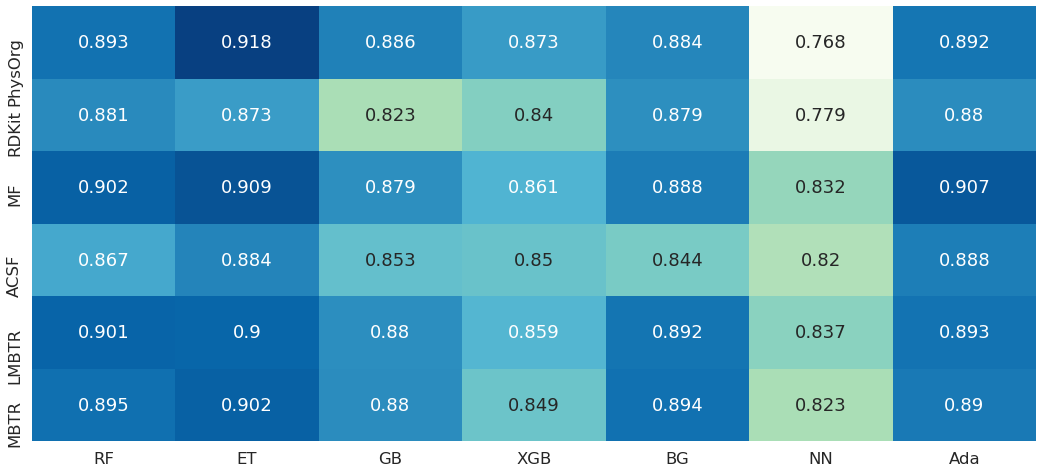

In [34]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        
        r2_map[j,i] = performance_result[(m,d)][1]

fig = plt.figure(figsize=(18,8))
plt.yticks(rotation=0)
sns.set(font_scale=1.5)
sns.heatmap(r2_map,annot=True,fmt='.3g',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu',cbar=False)